### To compute the pseudo-Cls for a specific disc I need first define it.

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt

In [2]:
# Reading the map and masks
planck_map = hp.read_map('/home/akozameh/cmblss/data/COM_CMB_IQU-smica_2048_R3.00_oe2.fits')
m_1 = hp.read_map('/home/akozameh/cmblss/data/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits')
m_2 = hp.read_map('/home/akozameh/cmblss/data/COM_Mask_CMB-HM-Misspix-Mask-Int_2048_R3.00.fits')

In [3]:
# Convert masks to numpy arrays with boolean dtype
m_1 = np.array(m_1, dtype=bool)
m_2 = np.array(m_2, dtype=bool)

In [4]:
# Combine masks using AND (common mask + Odd-Even missing pixels)
combined_mask = m_1 & m_2

setting the output map dtype to [dtype('bool')]


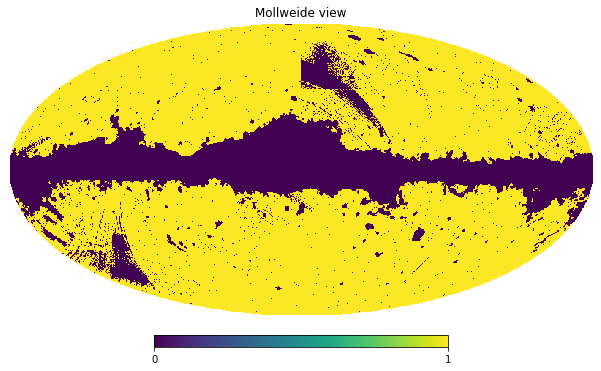

In [5]:
# Visualize the combined mask
hp.mollview(combined_mask)
hp.write_map("combined_mask.fits", combined_mask, overwrite=True)


In [6]:
# Apply the combined mask to the map
mask_1 = hp.read_map('combined_mask.fits')
smica_masked = hp.ma(planck_map)
smica_masked.mask = np.logical_not(mask_1)

In [7]:
# Smoothing the map
smica_masked = hp.smoothing(smica_masked, fwhm=np.radians(1.0))

In [8]:
# Downgrade the resolution of the map to NSIDE=4
nside_low = 4
smica_masked_low = hp.ud_grade(smica_masked, nside_low)

In [9]:
# Number of pixels of map at this resolution
NPIX = hp.nside2npix(nside_low)

In [10]:
# Retrieve the colatitude and longitude of each pixel on the map
theta, phi = hp.pix2ang(nside=nside_low, ipix=np.arange(NPIX))
vec = hp.ang2vec(theta, phi)

In [11]:
# Set the radius of the disc to 60 degrees
radius = np.radians(60.)
v = vec[0]  # Choosing the first vector for the disc center
disc = hp.query_disc(nside_low, v, radius)

In [12]:
# Create the disc mask at high resolution
nside_high = 16
disc_mask = np.zeros(hp.nside2npix(nside_high), dtype=bool)
disc_mask[disc] = True

In [13]:
# Upgrade the combined mask to the same resolution
combined_mask_high = hp.ud_grade(combined_mask, nside_high)

In [14]:
# Create the final mask by combining the disc mask and the Planck mask
final_mask = disc_mask & combined_mask_high

In [15]:
# Apply the final mask to the CMB map
smica_high = hp.ud_grade(planck_map, nside_high)
smica_masked_high = hp.ma(smica_high)
smica_masked_high.mask = np.logical_not(final_mask)


In [16]:
# Compute Cls using NaMaster
f_0 = nmt.NmtField(final_mask, [smica_masked_high])
# Initialize binning scheme with 4 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside_high, 4)

In [17]:
# Compute MASTER estimator
# spin-0 x spin-0
cl_00 = nmt.compute_full_master(f_0, f_0, b)

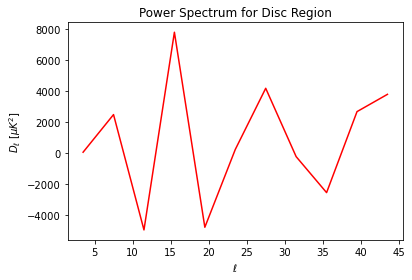

In [18]:
# Plot results
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_00[0]*ell_arr*(ell_arr+1)*[(1e6)**(2)]/2/np.pi, 'r-', label='TT for disc')
plt.xlabel('$\ell$')
plt.ylabel(r'$D_\ell~[\mu K^2]$')
plt.title('Power Spectrum for Disc Region')
plt.show()